<a href="https://colab.research.google.com/github/TrousersOMG/comp189cw2/blob/main/cw_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict schizophrenia from brain grey matter (classification)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Packages

In [2]:
import numpy as np
import scipy as sci
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
%matplotlib inline

## Load Data: ROIs

In [3]:
path = '/content/drive/MyDrive/UCL/comp189/brain_anatomy_schizophrenia_UCL_2023/data'

In [4]:
# 载入数据

# participants_train中的WM,GM,CSF数据在rois_train中都有但是 年龄，分类，还有性别数据是前者没有的

# 导入participants_train和rois_train
participants_train = pd.read_csv(os.path.join(path,"train_participants.csv"))
rois_train = pd.read_csv(os.path.join(path,"train_rois.csv"))

# 导入participants_test和rois_test
participants_test = pd.read_csv(os.path.join(path,"test_participants.csv"))
rois_test = pd.read_csv(os.path.join(path,"test_rois.csv"))

# 选择需要从participant数据中抽取的列
add_features = ["sex","age","diagnosis","site"]

# 对train和test做相同的操作，把重要feature插入rois的数据中
rois_extend_train = pd.concat([rois_train.iloc[:,0:2],participants_train[add_features],rois_train.iloc[:,3:]],axis=1)

rois_extend_test = pd.concat([rois_test.iloc[:,0:2],participants_test[add_features],rois_test.iloc[:,3:]],axis=1)




In [5]:
# 赋值给更简单的名字的变量
train_data = rois_extend_train
train_data['set'] = 'train'
test_data = rois_extend_test
test_data['set'] = 'test'

# combine train and test data together
data = pd.concat([train_data,test_data])

# Investigate the Distribution of the Data

### Check is there any missing data

In [6]:
def check_df(df):

    print('############### shape ###################')
    print(df.shape)

    print('############### summary of features ####################')
    null = df.isna().sum()
    missing_rate = (np.array(null)/(df.shape[0])).tolist()
    data = {'missing_number': null, 'missing_rate':missing_rate}
    missing_table = pd.DataFrame(data, index=df.columns)
    missing_table['missing_rate'] = missing_table['missing_rate'].apply(lambda x: format(x, '.2%'))
    missing_table['type'] = df.dtypes
    # print(missing_table)
    missing_table = pd.DataFrame(missing_table)
    
    return missing_table


check_list = check_df(data)
print(check_list)
num = check_list['missing_number'][check_list['missing_number']!=0].count()
print(f'There are {num} features has missing data.')

############### shape ###################
(513, 295)
############### summary of features ####################
                      missing_number missing_rate     type
participant_id                     0        0.00%   object
session                            0        0.00%   object
sex                                0        0.00%  float64
age                                0        0.00%  float64
diagnosis                          0        0.00%   object
...                              ...          ...      ...
lInfFroAngGy_CSF_Vol               0        0.00%  float64
rInfFroAngGy_CSF_Vol               0        0.00%  float64
lTemTraGy_CSF_Vol                  0        0.00%  float64
rTemTraGy_CSF_Vol                  0        0.00%  float64
set                                0        0.00%   object

[295 rows x 3 columns]
There are 0 features has missing data.


### Age

         age                                                    
       count       mean        std   min   25%   50%   75%   max
set                                                             
test   103.0  33.466019  12.809935  14.0  23.5  31.0  41.0  66.0
train  410.0  33.068293  12.562225  15.0  22.0  29.0  43.0  65.0
             age                                                    
           count       mean        std   min   25%   50%   75%   max
set   sex                                                           
test  0.0   65.0  34.184615  12.690908  16.0  24.0  32.0  43.0  65.0
      1.0   38.0  32.236842  13.088956  14.0  23.5  29.5  37.0  66.0
train 0.0  257.0  33.832685  12.812318  15.0  23.0  30.0  45.0  65.0
      1.0  153.0  31.784314  12.062851  15.0  22.0  26.0  42.0  60.0


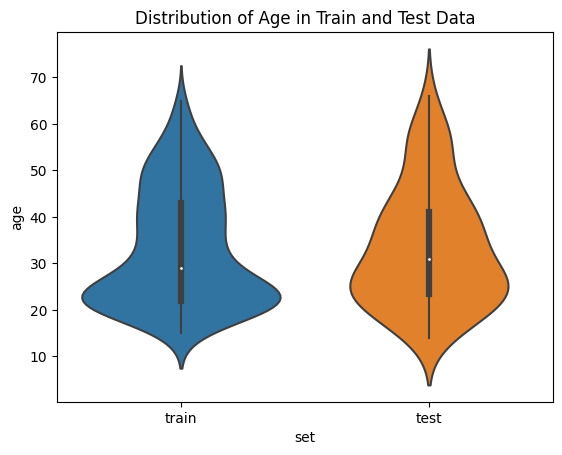

In [7]:
# Age
sns.violinplot(x='set',y='age',data=data).set_title('Distribution of Age in Train and Test Data')

# From the figure, we see that the distribution of age in this two dataset are quite similar(the mean, 0.25-0.75 intervel), but in the train data, the proportion of young people is higher than test one

print(data[['set','age']].groupby('set').describe())
print(data[['set','sex','age']].groupby(['set','sex']).describe())

# quantitatively, there is no significantly difference between the age in test, train dataset. Furthermore, if the group is divided more precisely, by train,test and sex, each subgroup has the similar distribution

### Sex

set    sex
test   0.0     65
       1.0     38
train  0.0    257
       1.0    153
dtype: int64


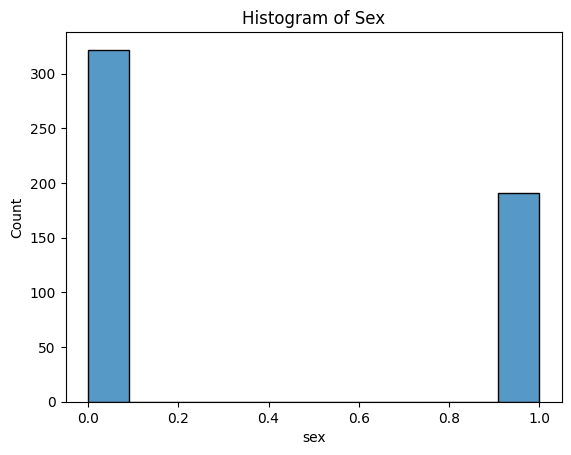

In [8]:
# sex
sns.histplot(x='sex',data=data).set_title('Histogram of Sex')

print(data.groupby(['set','sex']).size())

# in the sex, distibution are similar in test and train data, but it is imbalance.

### Diagnosis

set    diagnosis    
test   control           55
       schizophrenia     48
train  control          222
       schizophrenia    188
dtype: int64


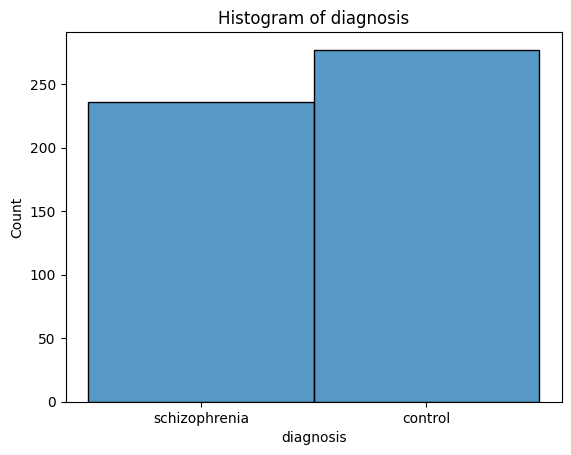

In [9]:
sns.histplot(x='diagnosis',data=data).set_title('Histogram of diagnosis')

print(data.groupby(['set','diagnosis']).size())

# Generally, the positive and negative sample are balance in train and test dataset

# Investigate the Feature that Could Related to Diagnosis 

In [10]:
# after 'l3thVen_GM_Vol', the columns are ROIs
corr_data = pd.concat([data.loc[:,'l3thVen_GM_Vol':],data['diagnosis']],axis=1)
corr_data = corr_data.drop('set',axis=1)

# change the str to num
map_dic = {'control':0,'schizophrenia':1}

corr_data['diagnosis'] = corr_data['diagnosis'].replace(map_dic)

In [11]:
# plot the heatmap
fig = plt.figure(figsize=(100,120))

sns.heatmap(np.abs(corr_data.corr()),cmap='Blues')

<Axes: >

！！！！！ try to understand the theorem behind this part

                            OLS Regression Results                            
Dep. Variable:                    PC1   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     29.25
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           9.81e-08
Time:                        16:03:24   Log-Likelihood:                -1878.6
No. Observations:                 513   AIC:                             3761.
Df Residuals:                     511   BIC:                             3770.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

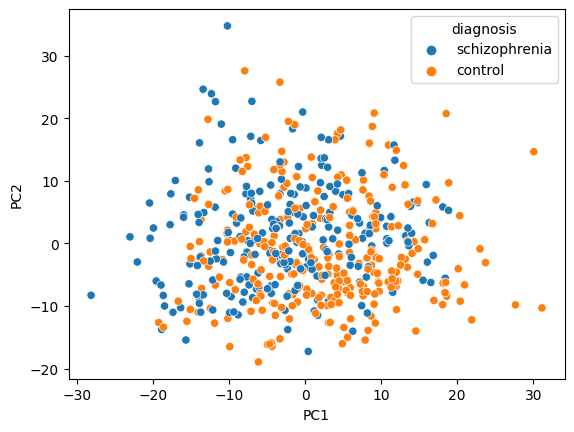

In [12]:
# PCA

from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

rois = corr_data.drop(['diagnosis'],axis=1)

PCs = PCA(n_components=2).fit_transform(rois)
data['PC1'], data['PC2']  = PCs[:, 0], PCs[:, 1]

sns.scatterplot (x="PC1", y="PC2", hue="diagnosis",  data=data)
# here we do a fitting to have a flavour in the relationship between PC1 and PC2 with the diagnosis
oneway = smf.ols('PC1 ~ diagnosis', data).fit()
print(oneway.summary())
print(sm.stats.anova_lm(oneway, typ=2))
oneway = smf.ols('PC2 ~ diagnosis', data).fit()
print(sm.stats.anova_lm(oneway, typ=2))


# From the ANONA table, we see that p-value are both smaller than 0.05, and we could reject that these two component has not contribution to the prediction of diagnosis.

# Machine Learning Part

In [13]:
!pip install ramp-workflow

# import package
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics

# change the direction to import the .py file
import sys
sys.path.append('/content/drive/MyDrive/UCL/comp189/brain_anatomy_schizophrenia_UCL_2023')
import problem

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.0/130.0 kB 7.4 MB/s eta 0:00:00


In [14]:
# load data
path = '/content/drive/MyDrive/UCL/comp189/brain_anatomy_schizophrenia_UCL_2023'
X_train, y_train = problem.get_train_data(path=path)
X_test, y_test = problem.get_test_data(path=path)


# ！！！！！为什么我不把.ipynb放在这个文件夹下，就读取不了文件？——因为在.py文件中读取路径设置的问题

In [15]:
# the assert statement is checking if the number of columns in X_train is equal to 331979. If the condition is True, then the code continues to execute as normal. However, if the condition is False, then the assert statement raises an AssertionError with a default error message indicating that the assertion has failed.

assert X_train.shape[1] == 284 + 331695

In [16]:
# this part only divided the data into low dimensional feature and high dimensional features

class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]

class VBMFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, 284:]


fe_roi = ROIsFeatureExtractor()
print(fe_roi.transform(X_train).shape)

fe_vbm = VBMFeatureExtractor()
print(fe_roi.transform(X_train).shape)

(410, 284)
(410, 284)


# Machine Learning Part

## Low Dimension: ROIs

In [17]:
# X_train = fe_roi.transform(X_train_all)
# y_train = y_train_all
# X_test = fe_roi.transform(X_test_all)
# y_test = y_test_all

In [18]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    MLPClassifier(random_state=1, hidden_layer_sizes=(200, 150, 100, 50, 25, )))
    
cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv, verbose=1, return_train_score=True, n_jobs=-1)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())


# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1] # give the probability to the two classification and select the probability that y_predict = 1

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


# 5CV
bACC=0.71 ROC-AUC=0.77
# Test
bACC=0.63 ROC-AUC=0.74


## Regular Linear Model: Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

The cross validation are KFold and StratifiedGroupKFold(Stratified represent the split of the target is flow the ratio, and Group means the split in the group is also follows the ratio)

In [41]:
# split theh data
N_FOLDS = 5

def get_cv_KFold(X, y):
    cv_train = KFold(n_splits=N_FOLDS, shuffle=True, random_state=0)
    return cv_train.split(X, y)

def get_cv_SGKFold(X, y):
    cv_train = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=0)
    group = rois_extend_train['sex']
    return cv_train.split(X, y, groups=group)




In [42]:
# mapping transform the str in y_train and y_test into int
def mapping(array):

    map_dic = {'schizophrenia':1, 'control':0}

    if array.dtype == object:
        arr = np.vectorize(map_dic.get)(array)
    else:
        arr = array
    return arr

In [43]:
# tranform the y_train and y_test
y_train = mapping(y_train)
y_test = mapping(y_test)

In [ ]:
# build the splits
cv_k = get_cv_KFold(X_train, y_train)

lr_estimator = make_pipeline(
    ROIsFeatureExtractor(),
    SelectKBest(score_func=f_classif),
    StandardScaler(),
    LogisticRegression(max_iter=10000, solver='saga', random_state=0)
)

lr_hp = {
    'selectkbest__k': np.linspace(2,284,num=47),
    'logisticregression__C': np.linspace(0, 5, num=10),
    'logisticregression__penalty': ['l1','l2','elasticnet',None]
}

scores = {'accuracy':'balanced_accuracy', 'recall':'recall', 'roc-auc':'roc_auc'}

lr_gs = GridSearchCV(lr_estimator, lr_hp, scoring=scores, cv=cv_k, n_jobs=-1, verbose=2.2, return_train_score=True, refit='recall')

lr_gs.fit(X_train, y_train)

print("Best parameters: ", lr_gs.best_params_)
print("Best score: ", lr_gs.best_score_)

Fitting 5 folds for each of 1880 candidates, totalling 9400 fits
